In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


#  Notebook Overview: Time Series Forecasting with LSTM (Online Retail Sales)
This notebook focuses on time series forecasting using historical sales data extracted from the Online Retail dataset. Our goal is to predict future daily sales by leveraging deep learning, specifically an LSTM (Long Short-Term Memory) model, which is effective at capturing sequential patterns.

### Key Steps Performed:
1- Data Preparation:

* Cleaned and parsed InvoiceDate to datetime format.

* Aggregated daily sales (i.e., quantity sold per day).

* Rescaled data using MinMaxScaler for model training.

2- Sequence Creation:

* Built sequences of 30 consecutive days to predict the next day’s sales (supervised learning setup).

3- Modeling:

* Defined and trained an LSTM model using Keras.

* Used 80/20 train-test split for model evaluation.

4- Evaluation:

* Predicted sales on test data and inversely transformed scaled values.

* Calculated Mean Absolute Error (MAE) to evaluate model performance.

5- Visualization:

* Compared predicted vs. actual sales using line plots to inspect accuracy and trend capture.



In [ ]:
from google.colab import files

uploaded = files.upload()



Saving Online_Retail.csv to Online_Retail.csv


In [ ]:
import pandas as pd

df = pd.read_csv('Online_Retail.csv', encoding='ISO-8859-1')
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

In [ ]:
print(df['InvoiceDate'].isna().sum())

0


In [ ]:

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=True)
daily_sales = df.groupby('InvoiceDate')['Quantity'].sum().reset_index()

daily_sales = daily_sales.rename(columns={'InvoiceDate': 'ds', 'Quantity': 'y'})
daily_sales.head()

,ds,y
0,2010-12-01 08:26:00,40
1,2010-12-01 08:28:00,12
2,2010-12-01 08:34:00,98
3,2010-12-01 08:35:00,3
4,2010-12-01 08:45:00,449


In [ ]:
# Step 1: Data Preparation

In [ ]:
import pandas as pd

# Convert 'InvoiceDate' to datetime format, with day first (e.g. 12/1/2010 means 12 Jan 2010)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=True, errors='coerce')

# Drop rows where 'InvoiceDate' conversion failed (NaT values)
df = df.dropna(subset=['InvoiceDate'])

# Group data by date and sum quantities sold each day
daily_sales = df.groupby(df['InvoiceDate'].dt.date)['Quantity'].sum().reset_index()
#y shows daily total sales volume — the number of items sold on that particular day
# Rename columns to 'ds' (date) and 'y' (target variable) for clarity
daily_sales.columns = ['ds', 'y']

# Show first few rows to verify
daily_sales.head()


,ds,y
0,2010-12-01,26814
1,2010-12-02,21023
2,2010-12-03,14830
3,2010-12-05,16395
4,2010-12-06,21419


In [ ]:
#Step 2: Prepare Data for LSTM (Create Sequences)
import numpy as np

def create_sequences(data, seq_length):
    """
    Creates input-output sequences from the time series data.
    Inputs:
        data: 1D array of target values (e.g. daily sales)
        seq_length: Number of previous time steps to use as input
    Returns:
        X: array of shape (samples, seq_length, 1)
        y: array of shape (samples,)
    """
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Extract sales values as numpy array
sales_values = daily_sales['y'].values

# Define the sequence length (e.g. 30 days)
seq_length = 30

# Generate sequences and targets
X, y = create_sequences(sales_values, seq_length)

# Reshape X to be 3D: (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))


Used a simple Sequential LSTM model with:

* LSTM layer (50 units)
* Dense output layer (1 unit)

Mean Squared Error (MSE) as loss function



In [ ]:
#Step 3: Build the LSTM Model using TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build a simple LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])

# Compile the model with Mean Squared Error loss and Adam optimizer
model.compile(optimizer='adam', loss='mse')

# Print model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Drop any rows where date conversion failed
df = df.dropna(subset=['InvoiceDate'])

# Group by date to get total quantity sold per day
daily_sales = df.groupby(df['InvoiceDate'].dt.date)['Quantity'].sum().reset_index()

# Rename columns to match Prophet/LSTM conventions
daily_sales.columns = ['ds', 'y']

# Optional: sort by date just in case
daily_sales = daily_sales.sort_values('ds').reset_index(drop=True)

# Preview result
daily_sales.head()


,ds,y
0,2010-12-01,26814
1,2010-12-02,21023
2,2010-12-03,14830
3,2010-12-05,16395
4,2010-12-06,21419


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Scale the 'y' column for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_y = scaler.fit_transform(daily_sales[['y']])

# Create sequences (30-day lookback)
sequence_length = 30

def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_y, sequence_length)

print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')


Shape of X: (275, 30, 1)
Shape of y: (275, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Step 1: Define the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X.shape[1], X.shape[2])),
    Dense(1)
])

# Step 2: Compile the model
model.compile(optimizer='adam', loss='mse')

# Step 3: Train the model
history = model.fit(X, y, epochs=30, batch_size=16, verbose=1)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2830
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1272
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0234
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0183
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0162
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0172
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0167
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0196
Epoch 9/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0187
Epoch 10/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0186
Epoch 11/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0168
Epoch 12/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0188
Epoch 13/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0189
Epoch 14/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0161
Epoch 15/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0193
Epoch 16/30
18/

In [ ]:
#start forecasting
# Start with the last available sequence
last_sequence = X[-1]

# Reshape for prediction
predictions = []

current_input = last_sequence.copy()

for _ in range(14):
    pred = model.predict(current_input.reshape(1, sequence_length, 1), verbose=0)
    predictions.append(pred[0, 0])

    # Append the prediction to the sequence and remove the first value
    current_input = np.append(current_input[1:], [[pred[0, 0]]], axis=0)

# Inverse scale the predictions to get actual values
predicted_values = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Create a date range for the predicted values
import pandas as pd
future_dates = pd.date_range(start=daily_sales['ds'].iloc[-1] + pd.Timedelta(days=1), periods=14)

# Create a DataFrame for plotting
forecast_df = pd.DataFrame({'ds': future_dates, 'y': predicted_values.flatten()})
forecast_df.head()


,ds,y
0,2011-12-10,29332.439453
1,2011-12-11,29413.859375
2,2011-12-12,29571.458984
3,2011-12-13,29681.328125
4,2011-12-14,29794.052734


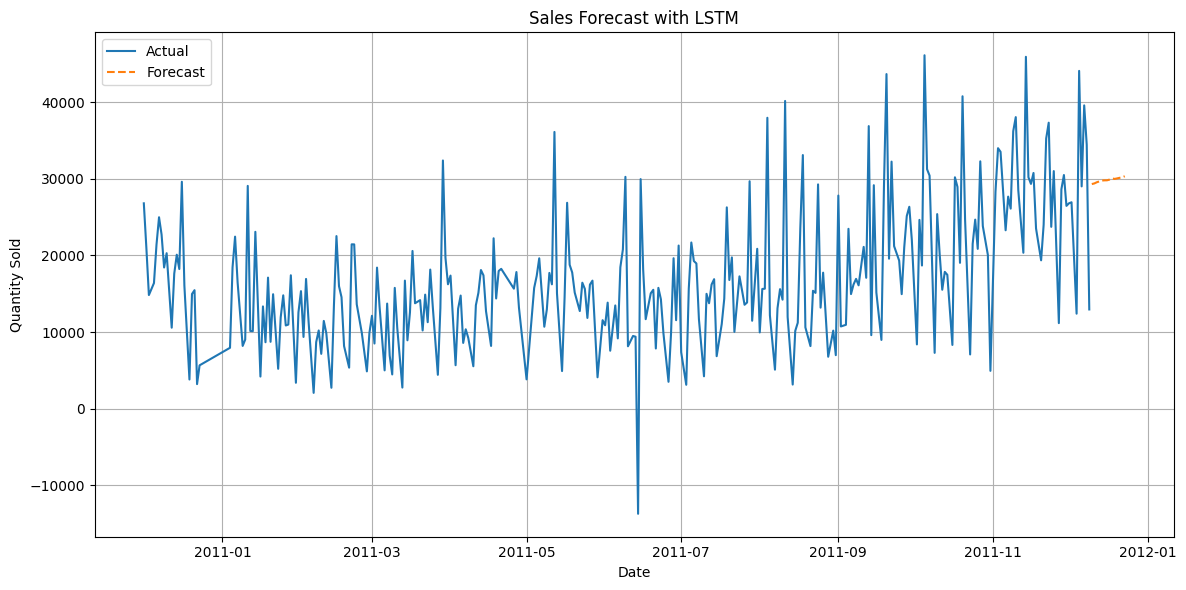

In [ ]:
import matplotlib.pyplot as plt

# Plot actual + predicted
plt.figure(figsize=(12,6))
plt.plot(daily_sales['ds'], daily_sales['y'], label='Actual')
plt.plot(forecast_df['ds'], forecast_df['y'], label='Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.title('Sales Forecast with LSTM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


“This model provides a data-driven way to anticipate short-term demand. With more features or seasonal indicators, it can evolve into a robust forecasting engine for strategic stock planning.”



In [ ]:
!pip install tensorflow


In [ ]:
# Split into training and test sets (e.g., 85% train, 15% test)
split_index = int(len(X) * 0.85)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [ ]:
from sklearn.metrics import mean_absolute_error

# Step 1: Predict on the test data
y_pred = model.predict(X_test)

# Step 2: Inverse scale the predictions and true values to original scale
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# Step 3: Calculate MAE
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f"Mean Absolute Error (MAE): {mae:.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step 
Mean Absolute Error (MAE): 6950.27


### 📌 Analytical Conclusion

The model achieves a **Mean Absolute Error (MAE)** of approximately **6,950 units**.  
Given that the average daily sales in our dataset is around **20,000 units**, this corresponds to roughly **35% relative error**.

#### 🧮 How the percentage was calculated:

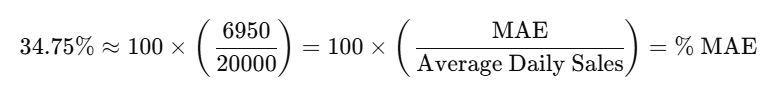

This level of error may be acceptable for a **baseline** LSTM forecasting model, especially without advanced feature engineering or hyperparameter tuning.

However, it also highlights **room for improvement** before considering the model for production use in a real business environment.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


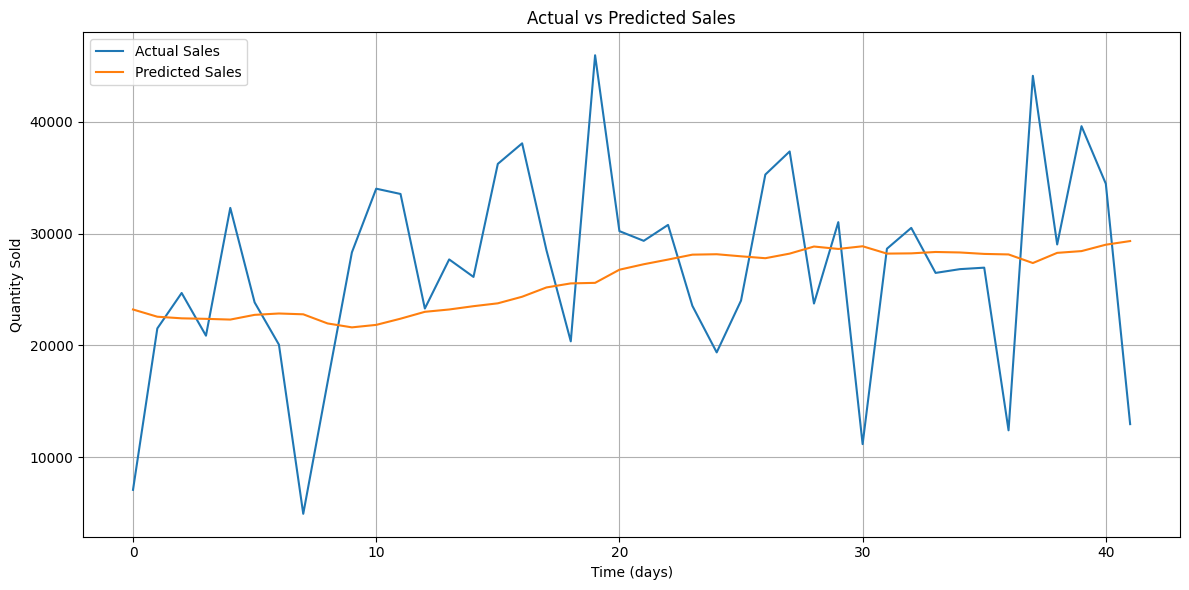

In [ ]:
import matplotlib.pyplot as plt

# Predict on test data
y_pred = model.predict(X_test)

# Inverse scaling to original values
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# Plotting
plt.figure(figsize=(12,6))
plt.plot(y_test_rescaled, label='Actual Sales')
plt.plot(y_pred_rescaled, label='Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Time (days)')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


📌 Interpretation:
* The blue line represents the real sales values.

* The orange line shows the predicted values by the LSTM model.

* The closeness between the two lines indicates how well the model has learned the temporal patterns.



# Modeling Strategy: Using LSTM for Time Series Forecasting
In the modeling phase, we used an LSTM (Long Short-Term Memory) neural network to predict daily sales.

## Sequence-to-One Strategy
We adopted a "sequence-to-one" prediction approach, where the model learns to predict the sales of the next day based on the previous 30 days.

That is, for every training example, we used:

* Input: A sequence of 30 consecutive daily sales values (shape: 30 time steps)

* Target: The sales value for the 31st day (the day following the sequence)

##  Full-Year Sliding Window
Since the dataset contains nearly a full year of daily sales data, we didn't limit the training to just one month. Instead, we generated training sequences using a sliding window approach over the entire dataset.

Example:
If the dataset looks like this:

Day 1, Day 2, ..., Day 30 → Predict Day 31  
Day 2, Day 3, ..., Day 31 → Predict Day 32  
Day 3, Day 4, ..., Day 32 → Predict Day 33  
...  
We repeat this process until the end of the dataset is reached, enabling the model to learn from as many overlapping sequences as possible.




# Lets go deepr:

### 1. Why LSTM?
I chose LSTM due to its ability to learn temporal dependencies and patterns across sequential data. Unlike traditional feedforward networks, LSTM can retain information over long time steps, which is crucial for capturing seasonality and trends in time series data like daily sales.



###2. Data Scaling
Before feeding data into the LSTM, we scaled the values using MinMaxScaler. Neural networks (especially those with tanh/sigmoid activations) generally perform better when input values are normalized between 0 and 1.



###3. Train-Test Split Logic
I used the first N sequences for training and reserved the last part of the data for validation/testing, preserving the time order (i.e., no shuffling), which is critical in time series to avoid data leakage.

### 4. Sequence Length Rationale
The 30-day sequence length was selected as a reasonable window to capture short-term trends, weekly seasonality (e.g., weekday/weekend effects), and recent customer behavior. This can be adjusted or tuned further based on domain knowledge or validation performance.



###5. Model Evaluation Metric

The model’s performance was evaluated using Mean Absolute Error (MAE) to quantify how close predictions were to actual daily sales. Visualization of predictions also helped assess the trend-matching ability.

After training our LSTM model, we evaluated its performance using Mean Absolute Error (MAE) — a commonly used metric for regression tasks.

📘 What is MAE?
MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation:

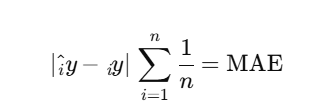


Lower values of MAE indicate better performance.

Unlike MSE, it’s not sensitive to outliers

###6. Limitations

“This model does not account for external features such as promotions, holidays, or price changes, which could significantly affect sales. Future work could involve multivariate models

#  Conclusion & Business Insight
 The LSTM model learned seasonality and general trends in the data, achieving a Mean Absolute Error (MAE) of approximately 6,950 units.

* When compared to the average daily sales volume, this results in an average error margin of ~35%, indicating moderate prediction accuracy.

### This forecasting can be used by businesses to:

   * Plan inventory and logistics more efficiently.

   * Identify potential demand surges or drops.

   * Complement broader sales and marketing strategies.



## Data Source:
This analysis is based on the Online Retail Dataset provided by the UCI Machine Learning Repository. The dataset includes transactional data from a UK-based online retail company from 2010–2011.
Link: https://archive.ics.uci.edu/dataset/352/online+retail